In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from skimage.filters import sobel
from skimage.color import rgb2gray
import cv2


In [2]:
import os
import pandas as pd
import re

# Path ke folder utama
base_dir = "/kaggle/input/dslayer-24/data_no_noise/train"

# List untuk menyimpan path gambar dan label
data = []

# Loop melalui subject (e.g., subject-1, subject-2, ...)
for subject in os.listdir(base_dir):
    subject_path = os.path.join(base_dir, subject)

    # Loop untuk 'fall' dan 'non_fall'
    for category in ["fall", "non_fall"]:
        category_path = os.path.join(subject_path, category)

        # Loop semua subfolder dalam kategori
        for action_folder in os.listdir(category_path):
            action_path = os.path.join(category_path, action_folder)
            for image_name in os.listdir(action_path):
                image_path = os.path.join(action_path, image_name)

                # Ekstrak bagian setelah angka dan underscore
                match = re.search(r'\d+_(.+?)/', image_path)  # Regex untuk menangkap bagian setelah angka dan underscore
                if match:
                    extracted_label = match.group(1)
                else:
                    extracted_label = None
                
                # Tentukan fall atau non_fall berdasarkan extracted_label
                fall_actions = ['backward_falls', 'forward_falls', 'left_falls', 
                                'right_falls', 'sitting_falls', 'standing_falls']
                label = 1 if extracted_label in fall_actions else 0  # 1 untuk fall, 0 untuk non_fall
                
                data.append((image_path, label))

# Konversi ke DataFrame
df = pd.DataFrame(data, columns=["image_path", "label"])

# Menampilkan hasil
print(df.head())


                                          image_path  label
0  /kaggle/input/dslayer-24/data_no_noise/train/s...      1
1  /kaggle/input/dslayer-24/data_no_noise/train/s...      1
2  /kaggle/input/dslayer-24/data_no_noise/train/s...      1
3  /kaggle/input/dslayer-24/data_no_noise/train/s...      1
4  /kaggle/input/dslayer-24/data_no_noise/train/s...      1


In [3]:
pd.set_option('display.max_colwidth', None)
df

,image_path,label
0,/kaggle/input/dslayer-24/data_no_noise/train/subject-1/fall/1_left_falls/frame019.jpg,1
1,/kaggle/input/dslayer-24/data_no_noise/train/subject-1/fall/1_left_falls/frame017.jpg,1
2,/kaggle/input/dslayer-24/data_no_noise/train/subject-1/fall/1_left_falls/frame016.jpg,1
3,/kaggle/input/dslayer-24/data_no_noise/train/subject-1/fall/1_left_falls/frame015.jpg,1
4,/kaggle/input/dslayer-24/data_no_noise/train/subject-1/fall/1_left_falls/frame021.jpg,1
...,...,...
3424,/kaggle/input/dslayer-24/data_no_noise/train/subject-3/non_fall/3_stretching/frame002.jpg,0
3425,/kaggle/input/dslayer-24/data_no_noise/train/subject-3/non_fall/3_stretching/frame007.jpg,0
3426,/kaggle/input/dslayer-24/data_no_noise/train/subject-3/non_fall/3_stretching/frame004.jpg,0
3427,/kaggle/input/dslayer-24/data_no_noise/train/subject-3/non_fall/3_stretching/frame067.jpg,0


In [4]:
df[df['image_path'] == '/kaggle/input/data-slayer-24/train/subject-1/fall/2_backward_falls/frame053.jpg']

,image_path,label


In [4]:
def load_and_preprocess_image(img_path, target_size=(256, 256)):
    # Baca gambar dengan OpenCV
    image = cv2.imread(img_path)
    
    # Ubah dari BGR ke RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    # Resize gambar ke ukuran target
    image_resized = cv2.resize(image_rgb, target_size)
    
    # Normalisasi piksel ke [0, 1]
    image_normalized = image_resized / 256.0

    return image_normalized

In [5]:
def image_generator(df, label_col):
    for _, row in df.iterrows():
        img_path = row['image_path']  # Path gambar langsung
        image = load_and_preprocess_image(img_path)
        label = row[label_col]
        yield image, label


In [6]:
def create_tf_dataset(df, label_col, batch_size=24):
    dataset = tf.data.Dataset.from_generator(
        lambda: image_generator(df, label_col),
        output_signature=(
            tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [9]:
def create_mobilenetv2_model(num_classes):
    base_model = tf.keras.applications.MobileNet(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def create_NASNetLarge_model(num_classes):
    base_model = tf.keras.applications.NASNetLarge(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_NASNetMobile_model(num_classes):
    base_model = tf.keras.applications.NASNetMobile(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
def train_model(model, train_dataset, epochs=10):
    model.fit(
        train_dataset,
        epochs=epochs
    )


In [11]:
from sklearn.model_selection import train_test_split

# Split dataset menjadi train dan validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Membuat dataset TensorFlow
train_dataset = create_tf_dataset(train_df, label_col='label', batch_size=24)
val_dataset = create_tf_dataset(val_df, label_col='label', batch_size=24)
train_all_dataset = create_tf_dataset(df, label_col='label', batch_size=24)

# Membuat model
num_classes = 2  # fall dan non_fall
model_mobilenetv2 = create_mobilenetv2_model(num_classes)
model_NASNetLarge = create_NASNetLarge_model(num_classes)
model_NASNetMobile = create_NASNetMobile_model(num_classes)

# Melatih model
train_model(model_mobilenetv2, train_all_dataset, epochs=30)


/tmp/ipykernel_23/2647934855.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30


I0000 00:00:1735116615.747389      67 service.cc:145] XLA service 0x7e4fcc0027c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735116615.747478      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


      1/Unknown 6s 6s/step - accuracy: 1.0000 - loss: 0.0449

I0000 00:00:1735116619.001778      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 407ms/step - accuracy: 0.6833 - loss: 52.0983
Epoch 2/30


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.6499 - loss: 81.9803
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 195ms/step - accuracy: 0.8730 - loss: 3.7911
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.8572 - loss: 7.2505
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - accuracy: 0.9469 - loss: 1.5003
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9525 - loss: 1.9281
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 201ms/step - accuracy: 0.9680 - loss: 0.8742
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.9921 - loss: 0.1965
Epoch 9/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.9977 - loss: 0.0790
Epoch 10/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.9991 - loss: 0.0183
Epoch 11/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 1.0000 - loss: 2.7255e-06
Epoch 12/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 1.0000 - loss: 9.5292e-06
Epoch 13/30
143/143 

In [11]:
val_df

,image_path,label
3531,/kaggle/input/data-slayer-24/train/subject-3/non_fall/3_laying/frame086.jpg,0
2863,/kaggle/input/data-slayer-24/train/subject-4/non_fall/4_stretching/frame102.jpg,0
4020,/kaggle/input/data-slayer-24/train/subject-3/non_fall/3_squat/frame031.jpg,0
3865,/kaggle/input/data-slayer-24/train/subject-3/non_fall/3_walking/frame051.jpg,0
3694,/kaggle/input/data-slayer-24/train/subject-3/non_fall/3_picking/frame081.jpg,0
...,...,...
1740,/kaggle/input/data-slayer-24/train/subject-2/non_fall/2_walking/frame092.jpg,0
785,/kaggle/input/data-slayer-24/train/subject-1/non_fall/1_laying/frame007.jpg,0
2552,/kaggle/input/data-slayer-24/train/subject-4/non_fall/4_walking/frame024.jpg,0
3453,/kaggle/input/data-slayer-24/train/subject-3/fall/3_left_falls/frame021.jpg,1


In [28]:
pred_mobilenetv2 = model_mobilenetv2.predict(val_dataset)
pred_mobilenetv2 = tf.argmax(pred_mobilenetv2, axis=1).numpy()

pred_NASNetLarge = model_NASNetLarge.predict(val_dataset)
pred_NASNetLarge = tf.argmax(pred_NASNetLarge, axis=1).numpy()

pred_NASNetMobile = model_NASNetMobile.predict(val_dataset)
pred_NASNetMobile = tf.argmax(pred_NASNetMobile, axis=1).numpy()

from sklearn.metrics import recall_score, confusion_matrix, accuracy_score



      8/Unknown 4s 152ms/step

KeyboardInterrupt: 

In [32]:
accuracy_score(pred_NASNetLarge, val_df['label'])

0.9970845481049563

In [33]:
accuracy_score(pred_mobilenetv2, val_df['label'])

0.9970845481049563

In [34]:
accuracy_score(pred_NASNetMobile, val_df['label'])

0.9912536443148688

In [36]:
accuracy_score(pred_mobilenetv2, pred_NASNetMobile)

0.9883381924198251

In [12]:
import os
import pandas as pd

# Path ke folder test
test_base_dir = "/kaggle/input/data-slayer-24/test"

# List untuk menyimpan path gambar
test_data = []

# Loop untuk menjelajahi semua subfolder dan file gambar
for root, dirs, files in os.walk(test_base_dir):
    for file in files:
        if file.endswith((".png", ".jpg", ".jpeg")):  # Filter untuk file gambar
            image_path = os.path.join(root, file)
            test_data.append(image_path)

# Konversi ke DataFrame
test_df = pd.DataFrame(test_data, columns=["image_path"])
print(test_df.head())
print(f"Total images found: {len(test_df)}")


                                         image_path
0  /kaggle/input/data-slayer-24/test/6e001dec60.jpg
1  /kaggle/input/data-slayer-24/test/ae5930d570.jpg
2  /kaggle/input/data-slayer-24/test/f0158f240a.jpg
3  /kaggle/input/data-slayer-24/test/62c5b268ef.jpg
4  /kaggle/input/data-slayer-24/test/91d93bb89b.jpg
Total images found: 2152


In [13]:
def predict_images(model, df, batch_size=24):
    # Generator untuk test dataset
    def test_image_generator(df):
        for _, row in df.iterrows():
            img_path = row['image_path']
            image = load_and_preprocess_image(img_path)
            yield image

    # Dataset TensorFlow untuk test
    test_dataset = tf.data.Dataset.from_generator(
        lambda: test_image_generator(df),
        output_signature=tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32)
    ).batch(batch_size)

    # Prediksi
    predictions = model.predict(test_dataset)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()
    return predicted_classes


In [14]:
# Membuat prediksi pada data test
predicted_mobilenetv2 = predict_images(model_mobilenetv2, test_df)


# Menambahkan kolom prediksi ke DataFrame test
test_df['mobilenetv2'] = predicted_mobilenetv2


# Menyimpan hasil prediksi ke file CSV untuk submit
submission_path = "/kaggle/working/submission.csv"



90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 427ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [15]:
test_df

,image_path,mobilenetv2,NASNetLarge,NASNetMobile
0,/kaggle/input/data-slayer-24/test/6e001dec60.jpg,1,0,0
1,/kaggle/input/data-slayer-24/test/ae5930d570.jpg,1,0,1
2,/kaggle/input/data-slayer-24/test/f0158f240a.jpg,0,0,0
3,/kaggle/input/data-slayer-24/test/62c5b268ef.jpg,1,1,1
4,/kaggle/input/data-slayer-24/test/91d93bb89b.jpg,0,0,0
...,...,...,...,...
2147,/kaggle/input/data-slayer-24/test/0b6b58929e.jpg,0,0,1
2148,/kaggle/input/data-slayer-24/test/f9a6ed67f4.jpg,1,1,1
2149,/kaggle/input/data-slayer-24/test/afb4ab9da2.jpg,1,0,1
2150,/kaggle/input/data-slayer-24/test/405d029d34.jpg,0,0,0


In [40]:
import pandas as pd
from scipy.stats import mode

# Misalkan test_df sudah ada dan berisi kolom 'mobilenetv2', 'NASNetLarge', 'NASNetMobile'
# Gabungkan ketiga kolom dalam sebuah DataFrame
vote_df = test_df[['mobilenetv2', 'NASNetLarge', 'NASNetMobile']]

# Lakukan voting pada setiap baris (axis=1 untuk voting per baris)
test_df['voting_result'] = vote_df.mode(axis=1)[0]  # Ambil hasil voting yang paling sering muncul

# Menampilkan hasil voting
print(test_df[['mobilenetv2', 'NASNetLarge', 'NASNetMobile', 'voting_result']])


      mobilenetv2  NASNetLarge  NASNetMobile  pr  voting_result
0               1            0             0   1            0.0
1               1            0             1   1            1.0
2               0            0             0   0            0.0
3               1            1             1   1            1.0
4               0            0             0   0            0.0
...           ...          ...           ...  ..            ...
2147            0            0             1   0            0.0
2148            1            1             1   1            1.0
2149            1            0             1   0            0.0
2150            0            0             0   0            0.0
2151            1            0             1   1            1.0

[2152 rows x 5 columns]


In [15]:
import os
submission_path = "/kaggle/working/submission.csv"
# Ambil hanya nama file dari kolom 'image_path'
test_df['image_path'] = test_df['image_path'].apply(lambda x: os.path.basename(x))

# Tampilkan hasil
print(test_df.head())


       image_path  mobilenetv2
0  6e001dec60.jpg            1
1  ae5930d570.jpg            1
2  f0158f240a.jpg            0
3  62c5b268ef.jpg            1
4  91d93bb89b.jpg            1


In [16]:
test_df.rename(columns={'image_path': 'id'}, inplace=True)

In [17]:
test_df

,id,mobilenetv2
0,6e001dec60.jpg,1
1,ae5930d570.jpg,1
2,f0158f240a.jpg,0
3,62c5b268ef.jpg,1
4,91d93bb89b.jpg,1
...,...,...
2147,0b6b58929e.jpg,0
2148,f9a6ed67f4.jpg,1
2149,afb4ab9da2.jpg,0
2150,405d029d34.jpg,0


In [18]:
test_df.to_csv(submission_path, index=False)
print(f"File submission saved to: {submission_path}")

File submission saved to: /kaggle/working/submission.csv


In [24]:
test_df[test_df['label'] == 3]

KeyError: 'label'

In [15]:
submission_path = "/kaggle/working/submission.csv"
test_df[['id', 'label']].to_csv(submission_path, index=False)
print(f"File submission saved to: {submission_path}")


File submission saved to: /kaggle/working/submission.csv


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import YolosImageProcessor, YolosForObjectDetection


# Split dataset menjadi train dan validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
model_obj = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
processor_obj = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

def preprocess_image(filepath: str, crop: bool = False, rotate: bool = False, threshold: float = 0.5):
    # Load image
    image = Image.open(filepath).convert("RGB")
    
    # Perform object detection
    with torch.no_grad():  # Disable gradient computation for inference
        inputs = processor_obj(images=image, return_tensors="pt")
        outputs = model_obj(**inputs)
    
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor_obj.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]
    
    # Crop image if needed
    if crop:
        person_label_id = model_obj.config.label2id.get("person")
        if person_label_id is not None:
            best_box = None
            best_score = 0
            for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
                if label.item() == person_label_id and score.item() > best_score:
                    best_score = score.item()
                    best_box = box
            
            if best_box is not None:
                x_min, y_min, x_max, y_max = map(int, best_box.tolist())
                image = image.crop((x_min, y_min, x_max, y_max))
            else:
                print(f"No 'person' label detected with sufficient score in image: {filepath}")
    
    # Resize image to target dimensions
    image = image.resize((256, 256))
    
    # Rotate image if needed
    if rotate:
        image = image.rotate(90)
    
    return image



config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

In [6]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ImageClassificationDataset(Dataset):
    def __init__(self, df, processor, label_encoder):
        self.df = df
        self.processor = processor
        self.label_encoder = label_encoder

        self.images = [preprocess_image(path, crop=True) for path in df['image_path']]
        self.labels = label_encoder.fit_transform(df['label'])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Proses gambar
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        return {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [7]:
from transformers import TrOCRProcessor, ViTImageProcessor
from transformers import VisionEncoderDecoderModel

model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Ganti dengan jumlah kelas Anda
    id2label={i: label for i, label in enumerate(['non_fall', 'fall'])},  # Mapping id ke label
    label2id={label: i for i, label in enumerate(['non_fall', 'fall'])},  # Mapping label ke id
    ignore_mismatched_sizes=True  # Menangani ukuran layer yang tidak cocok
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
label_encoder = LabelEncoder()
train_dataset = ImageClassificationDataset(df=df, processor=processor, label_encoder=label_encoder)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

No 'person' label detected with sufficient score in image: /kaggle/input/dslayer-24/data_no_noise/train/subject-1/fall/1_standing_falls/frame021.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/dslayer-24/data_no_noise/train/subject-1/fall/1_standing_falls/frame023.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/dslayer-24/data_no_noise/train/subject-1/fall/1_standing_falls/frame022.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/dslayer-24/data_no_noise/train/subject-1/fall/1_forward_falls/frame016.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/dslayer-24/data_no_noise/train/subject-1/fall/1_forward_falls/frame013.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/dslayer-24/data_no_noise/train/subject-1/fall/1_forward_falls/frame010.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/dslayer-24/data_no_noise/train/subje

In [9]:
torch.save(train_dataset, "/kaggle/working/train_dataset.pth")

In [9]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
""
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [10]:

for epoch in range(10):  # Ganti jumlah epoch sesuai kebutuhan
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Loss after epoch {epoch+1}: {train_loss / len(train_dataloader):.4f}")

Epoch 1: 100%|██████████| 429/429 [01:20<00:00,  5.31it/s]


Loss after epoch 1: 0.0932


Epoch 2: 100%|██████████| 429/429 [01:20<00:00,  5.36it/s]


Loss after epoch 2: 0.0233


Epoch 3: 100%|██████████| 429/429 [01:19<00:00,  5.37it/s]


Loss after epoch 3: 0.0171


Epoch 4: 100%|██████████| 429/429 [01:19<00:00,  5.37it/s]


Loss after epoch 4: 0.0023


Epoch 5: 100%|██████████| 429/429 [01:19<00:00,  5.38it/s]


Loss after epoch 5: 0.0187


Epoch 6: 100%|██████████| 429/429 [01:19<00:00,  5.37it/s]


Loss after epoch 6: 0.0004


Epoch 7: 100%|██████████| 429/429 [01:19<00:00,  5.38it/s]


Loss after epoch 7: 0.0001


Epoch 8: 100%|██████████| 429/429 [01:19<00:00,  5.38it/s]


Loss after epoch 8: 0.0001


Epoch 9: 100%|██████████| 429/429 [01:19<00:00,  5.38it/s]


Loss after epoch 9: 0.0000


Epoch 10: 100%|██████████| 429/429 [01:19<00:00,  5.37it/s]

Loss after epoch 10: 0.0000


In [ ]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Dataset untuk prediksi
class PredictionDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]["image_path"]
        image = preprocess_image(image_path, crop=True)
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        return {"pixel_values": pixel_values.squeeze(0)}

# DataFrame untuk prediksi (misalnya pred_df)
# pred_df hanya perlu kolom 'image_path'
prediction_dataset = PredictionDataset(df=test_df, processor=processor)
prediction_dataloader = DataLoader(prediction_dataset, batch_size=4, shuffle=False)

# Proses prediksi
model.eval()
predictions = []

with torch.no_grad():  # Nonaktifkan gradien untuk prediksi
    for batch in tqdm(prediction_dataloader):
        pixel_values = batch["pixel_values"].to(device)

        # Forward pass
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits  # Logit dari model

        # Prediksi label
        preds = torch.argmax(logits, dim=-1)  # Ambil indeks dengan nilai logit tertinggi
        predictions.extend(preds.cpu().numpy())  # Simpan hasil prediksi ke list



  1%|          | 5/538 [00:08<14:21,  1.62s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/e39c0af8ba.jpg


  1%|          | 6/538 [00:09<14:24,  1.63s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/f4d9cc55c6.jpg


  1%|▏         | 7/538 [00:11<14:20,  1.62s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/03e7219604.jpg


  2%|▏         | 12/538 [00:19<14:05,  1.61s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/0bc9291d18.jpg


  3%|▎         | 18/538 [00:30<14:56,  1.72s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/0c337afbc3.jpg


  4%|▍         | 24/538 [00:39<14:18,  1.67s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/8e46188f51.jpg


  5%|▌         | 27/538 [00:44<14:09,  1.66s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/9aecde304d.jpg


  5%|▌         | 28/538 [00:46<14:10,  1.67s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/deac3cd949.jpg


  6%|▌         | 31/538 [00:51<14:08,  1.67s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/56fc4c759b.jpg


  7%|▋         | 36/538 [01:00<15:00,  1.79s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/62163af2f5.jpg


  7%|▋         | 39/538 [01:05<14:15,  1.71s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/da92ef93aa.jpg


  8%|▊         | 44/538 [01:14<13:42,  1.66s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/0a9f4a098a.jpg


  9%|▉         | 48/538 [01:20<13:13,  1.62s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/ec2c28342a.jpg


 10%|▉         | 52/538 [01:26<13:06,  1.62s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/e815f750d0.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/99396c4a2b.jpg


 11%|█         | 59/538 [01:38<13:00,  1.63s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/c6bcd410e8.jpg


 11%|█         | 60/538 [01:40<13:06,  1.65s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/1ece69f362.jpg


 11%|█▏        | 61/538 [01:42<13:06,  1.65s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/5d4f922e25.jpg


 12%|█▏        | 63/538 [01:45<12:53,  1.63s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/809df45153.jpg


 12%|█▏        | 65/538 [01:48<12:44,  1.62s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/a523f3227d.jpg


 12%|█▏        | 66/538 [01:50<12:49,  1.63s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/9a6955b6ae.jpg


 13%|█▎        | 68/538 [01:53<12:38,  1.61s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/10db799786.jpg


 13%|█▎        | 69/538 [01:55<12:43,  1.63s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/b6e5fec0bf.jpg


 15%|█▌        | 81/538 [02:15<12:46,  1.68s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/66280a3461.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/62580d598f.jpg


 16%|█▌        | 86/538 [02:23<12:31,  1.66s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/8edb020386.jpg


 16%|█▌        | 87/538 [02:25<12:35,  1.68s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/5ccd6f1521.jpg


 18%|█▊        | 99/538 [02:45<12:10,  1.66s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/a69b905720.jpg


 20%|██        | 108/538 [03:01<12:04,  1.68s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/0e03ff1494.jpg


 21%|██        | 114/538 [03:11<12:23,  1.75s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/895a7f7b4b.jpg


 22%|██▏       | 119/538 [03:20<11:35,  1.66s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/f51b039c59.jpg


 22%|██▏       | 121/538 [03:23<11:17,  1.62s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/ee4d037a1a.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/96633876c7.jpg


 23%|██▎       | 126/538 [03:31<11:06,  1.62s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/f8ff64b2de.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/3e2a6b7798.jpg


 27%|██▋       | 143/538 [03:59<11:01,  1.67s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/8122704f31.jpg


 27%|██▋       | 146/538 [04:04<10:44,  1.64s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/9d833b80ee.jpg


 28%|██▊       | 150/538 [04:11<11:26,  1.77s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/37528180ab.jpg


 28%|██▊       | 151/538 [04:13<11:14,  1.74s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/34d638479a.jpg


 28%|██▊       | 153/538 [04:16<10:50,  1.69s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/c7e8abad47.jpg


 30%|██▉       | 161/538 [04:30<10:21,  1.65s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/d18a6b185d.jpg


 31%|███       | 165/538 [04:36<10:17,  1.66s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/1af4316145.jpg


 34%|███▍      | 183/538 [05:06<09:47,  1.65s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/d725bffbb9.jpg


 35%|███▍      | 187/538 [05:13<10:18,  1.76s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/ba2e222b3f.jpg


 35%|███▌      | 190/538 [05:19<09:53,  1.71s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/0d1e29ac61.jpg


 36%|███▌      | 192/538 [05:22<09:36,  1.67s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/d743e54022.jpg


 37%|███▋      | 197/538 [05:30<09:16,  1.63s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/829de773d5.jpg


 37%|███▋      | 198/538 [05:32<09:18,  1.64s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/e062b9a2b5.jpg


 38%|███▊      | 206/538 [05:45<09:04,  1.64s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/6da9148167.jpg


 39%|███▊      | 208/538 [05:48<09:32,  1.74s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/1704ffaaf2.jpg


 41%|████      | 218/538 [06:05<08:42,  1.63s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/c6842415ee.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/6b4f41fd22.jpg


 41%|████▏     | 223/538 [06:13<08:38,  1.65s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/e7eddc4859.jpg


 43%|████▎     | 231/538 [06:27<08:31,  1.67s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/c3fbd36fe7.jpg


 43%|████▎     | 232/538 [06:28<08:27,  1.66s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/7d721c4ea4.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/ab6ec1b1bc.jpg


 46%|████▋     | 249/538 [06:57<08:17,  1.72s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/1bc5d5cdaf.jpg


 48%|████▊     | 259/538 [07:14<07:44,  1.66s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/4379d0ebe1.jpg


 49%|████▊     | 261/538 [07:18<07:43,  1.67s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/3e0adfb989.jpg


 49%|████▉     | 263/538 [07:22<08:41,  1.90s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/1fb81ebed5.jpg
No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/389ff89f18.jpg


 50%|█████     | 270/538 [07:33<07:30,  1.68s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/5c8556e60e.jpg


 51%|█████     | 272/538 [07:37<07:30,  1.69s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/aa3f6b8b9b.jpg


 51%|█████     | 274/538 [07:40<07:32,  1.71s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/1ff98be345.jpg


 52%|█████▏    | 282/538 [07:54<08:05,  1.90s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/e4fc2788dc.jpg


 53%|█████▎    | 285/538 [08:00<07:27,  1.77s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/07bc1f240e.jpg


 53%|█████▎    | 286/538 [08:01<07:20,  1.75s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/97f738cab8.jpg


 55%|█████▌    | 297/538 [08:20<06:47,  1.69s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/7b87b1c629.jpg


 55%|█████▌    | 298/538 [08:21<06:43,  1.68s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/b69f9fe696.jpg


 56%|█████▌    | 299/538 [08:23<06:42,  1.68s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/cbc68cde81.jpg


 56%|█████▋    | 303/538 [08:31<07:02,  1.80s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/c4a43e8692.jpg


 57%|█████▋    | 305/538 [08:34<06:43,  1.73s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/62ec7d46a0.jpg


 57%|█████▋    | 308/538 [08:39<06:30,  1.70s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/35caee35c5.jpg


 57%|█████▋    | 309/538 [08:41<06:32,  1.72s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/e8e2695121.jpg


 58%|█████▊    | 310/538 [08:42<06:31,  1.72s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/806875fc87.jpg


 59%|█████▉    | 318/538 [08:56<06:03,  1.65s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/d5b7195f04.jpg


 61%|██████    | 329/538 [09:15<05:45,  1.65s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/1b3e5c4f8e.jpg


 61%|██████▏   | 330/538 [09:16<05:41,  1.64s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/d69e32b486.jpg


 62%|██████▏   | 332/538 [09:20<05:40,  1.66s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/41c72a1f84.jpg


 65%|██████▍   | 348/538 [09:47<05:16,  1.67s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/3d3829ecc6.jpg


 65%|██████▌   | 351/538 [09:52<05:12,  1.67s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/156c581e9c.jpg


 66%|██████▌   | 355/538 [09:59<05:03,  1.66s/it]

No 'person' label detected with sufficient score in image: /kaggle/input/data-slayer-24/test/16d3cc83ae.jpg


 66%|██████▋   | 357/538 [10:02<05:20,  1.77s/it]

In [ ]:
predictions

In [20]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score

accuracy_score(predictions, val_df['label'])

1.0

In [13]:
test_df.rename(columns={'image_path': 'id'}, inplace=True)

In [14]:
test_df['label'] = predictions

In [20]:
test_df

,id,label
0,6e001dec60.jpg,1
1,ae5930d570.jpg,1
2,f0158f240a.jpg,0
3,62c5b268ef.jpg,1
4,91d93bb89b.jpg,0
...,...,...
2147,0b6b58929e.jpg,0
2148,f9a6ed67f4.jpg,1
2149,afb4ab9da2.jpg,1
2150,405d029d34.jpg,1


In [4]:
pip install torch torchvision transformers


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from transformers import YolosImageProcessor, YolosForObjectDetection
import torch
from PIL import Image
import requests

url = '/kaggle/input/data-slayer-24/train/subject-2/non_fall/2_squat/frame053.jpg'
image = image = Image.open(url).convert("RGB")

# you can specify the revision tag if you don't want the timm dependency
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected person with confidence 0.627 at location [555.62, 349.87, 682.9, 540.87]


In [126]:
label.item()

1

In [7]:
from PIL import Image


image = Image.open('/kaggle/input/data-slayer-24/train/subject-2/non_fall/2_squat/frame053.jpg').convert("RGB")

# Koordinat kotak (bounding box)
x_min, y_min, x_max, y_max = [570.57, 448.24, 985.49, 572.06]

# Potong gambar (koordinat harus berupa integer)
cropped_image = image.crop((int(x_min), int(y_min), int(x_max), int(y_max)))




In [138]:
image = image = Image.open(url).convert("RGB")

In [86]:
zip(results["scores"], results["labels"], results["boxes"])

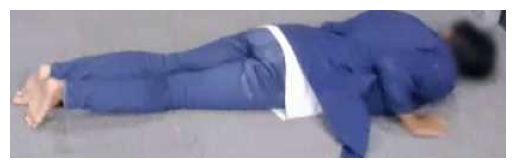

In [8]:
import matplotlib.pyplot as plt

# Tampilkan gambar menggunakan matplotlib
plt.imshow(cropped_image)
plt.axis("off")  # Hilangkan sumbu
plt.show()